In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from classifier import *
torch.cuda.is_available(), torch.backends.cudnn.enabled

/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(True, True)

In [2]:
def add_class_col(df, cats=['melanoma', 'keratosis']):
    df['classes'] = np.nan
    for c in cats:
        print('adding %s to class' % c)
        df['classes'].iloc[df[c].nonzero()[0]] = c
    df['classes'].fillna('nevus', inplace=True)
    df.head()
    return df

def vis_classes(df, col='classes'):
    df[col].value_counts().plot(kind='barh')
    print(df[col].value_counts())

In [3]:
PATH = Path('/home/sean/hpc-home/skin_cancer/')
test_folder = 'ISIC/ISIC-2017_Test_v2_Data_Classification/'
test_csv = PATH / 'ISIC/test_isic17.csv'

test_mel_p = PATH / 'ISIC/test_mel_17.csv'
test_ker_p = PATH / 'ISIC/test_ker_17.csv'
test_all_p = PATH / 'ISIC/test_all_17.csv'
test_raw_p = PATH / 'ISIC/test_raw_17.csv'

train_skp = PATH / 'train_multi_sk.csv'
train_melp = PATH / 'train_multi_mel.csv'
train_all = PATH / 'train_multi.csv'
train_raw = PATH / 'train_multi_raw.csv'

train_raw_half_ia_nervi = PATH / 'train_multi_raw_half_ia_nervi.csv'
train_all_half_ia_nervi = PATH / 'train_multi_half_ia_nervi.csv'

train_raw_no_ia_nervi = PATH / 'train_multi_raw_no_ia_nervi.csv'
train_all_no_ia_nervi = PATH / 'train_multi_half_no_nervi.csv'

%ls $PATH

dermofit/                        train_multi_half_ia_nervi.csv*
ISIC/                            train_multi_mel.csv*
isic18_p3_test_data*             train_multi_no_ia_nervi.csv*
isic_archive/                    train_multi_raw.csv*
models/                          train_multi_raw_half_ia_nervi.csv*
ph2dataset/                      train_multi_raw_no_ia_nervi.csv*
test_isic17_dermofitLabels.csv*  train_multi_sk.csv*
tmp/                             train_seg_isic17_dermo.csv*
train_dermofit_isic17.csv*       train_test_Mel_seg_isic17_dermo.csv*
train_Mel_seg_isic17_dermo.csv*  val_isic17.csv*
train_multi.csv*


### Testset all

nevus                   393
melanoma                117
seborrheic_keratosis     90
Name: classes, dtype: int64


,classes
ISIC/ISIC-2017_Test_v2_Data_Classification/ISIC_0012086.jpg,seborrheic_keratosis
ISIC/ISIC-2017_Test_v2_Data_Classification/ISIC_0012092.jpg,nevus
ISIC/ISIC-2017_Test_v2_Data_Classification/ISIC_0012095.jpg,nevus
ISIC/ISIC-2017_Test_v2_Data_Classification/ISIC_0012134.jpg,seborrheic_keratosis
ISIC/ISIC-2017_Test_v2_Data_Classification/ISIC_0012136.jpg,seborrheic_keratosis


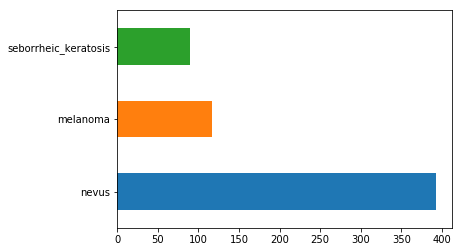

In [21]:
test_df = pd.read_csv(test_all_p, index_col=0)
# df_idl = list(test_df.index)
# new_index = [i.replace('/ISIC-2017_Test_v2_Data/', '/ISIC-2017_Test_v2_Data_Classification/') for i in df_idl]
# val_paths = all([(PATH / i).exists() for i in new_index])
# print('Are the paths valid: ', val_paths)
# test_df.index = new_index

# test_df.to_csv(test_all_p)
vis_classes(test_df, 'classes')
test_df.head()

nevus                   393
melanoma                117
seborrheic_keratosis     90
Name: classes, dtype: int64


,image_id,classes
0,ISIC_0012086,seborrheic_keratosis
1,ISIC_0012092,nevus
2,ISIC_0012095,nevus
3,ISIC_0012134,seborrheic_keratosis
4,ISIC_0012136,seborrheic_keratosis


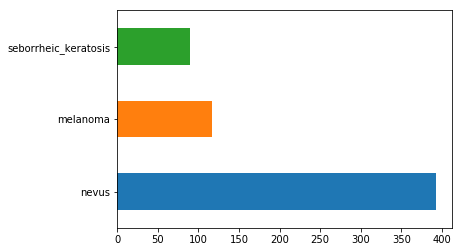

In [5]:
test_df2 = pd.read_csv(test_csv)
vis_classes(test_df2, 'classes')
test_df2.head()

nevus        4460
melanoma      847
keratosis     308
Name: class, dtype: int64


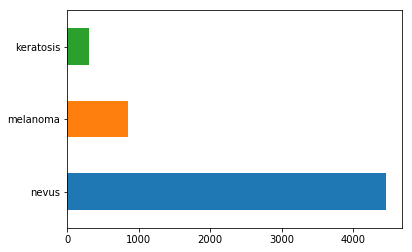

In [11]:
train_df = pd.read_csv(train_all)
vis_classes(train_df, 'class')
# train_df.columns

In [17]:
train_df.columns = ['image', 'class']
train_df.head()

,image,class
0,isic_archive/images/5436e3acbae478396759f0e5.jpg,nevus
1,isic_archive/images/5593f47b9fc3c131551460fc.jpg,nevus
2,isic_archive/images/5436e3f4bae478396759f4a6.jpg,nevus
3,isic_archive/images/558d637cbae47801cf734dbc.jpg,melanoma
4,isic_archive/images/558d60e8bae47801cf7345b2.jpg,melanoma


## Rec dataset load

In [18]:
dep = PATH / 'isic_archive/recod_titans_sub/data/deploy2017.txt'
rec = pd.read_csv(dep)
rec.columns = [ss.strip() for ss in rec.columns]
rec = rec.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
rec.head()

,image,case,type,age,has_age,sex,has_sex,melanoma,keratosis,schedule,weight,dataset
0,adl379,4A378379,d,45,1,female,1,0,0,2,3,atlas
1,ael455,4A454455,d,57,1,male,1,0,0,2,3,atlas
2,ael469,4A468469,d,68,1,female,1,0,0,1,3,atlas
3,ael502,4A501502,d,40,1,female,1,0,0,2,3,atlas
4,ael505,4A505505,d,65,1,male,1,0,0,2,3,atlas


## ISIC Archive

In [45]:
def getds(data): return rec.loc[rec['dataset'] == data][['image', 'melanoma', 'keratosis']]
ia = getds('isic')
ia = ia[['melanoma', 'keratosis']].set_index('isic_archive/images/' + ia['image'] + '.jpg')
ia = add_class_col(ia)
ia.head()

adding melanoma to class
adding keratosis to class


/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,melanoma,keratosis,classes
image,,,
isic_archive/images/5436e3acbae478396759f0e5.jpg,0,0,nevus
isic_archive/images/5593f47b9fc3c131551460fc.jpg,0,0,nevus
isic_archive/images/5436e3f4bae478396759f4a6.jpg,0,0,nevus
isic_archive/images/558d637cbae47801cf734dbc.jpg,1,0,melanoma
isic_archive/images/558d60e8bae47801cf7345b2.jpg,1,0,melanoma


nevus        3335
melanoma      701
keratosis       9
Name: classes, dtype: int64


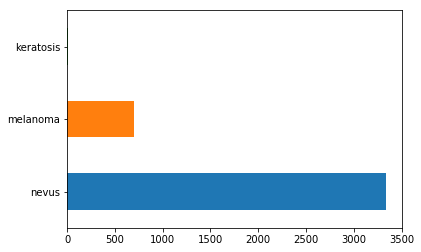

In [65]:
vis_classes(ia)

In [30]:
ia['keratosis'].value_counts()

0    4036
1       9
Name: keratosis, dtype: int64

In [69]:
ia_nervi_id = np.array((ia['classes'] != 'nevus'))
print(ia_nervi_id, sum(ia_nervi_id))

[False False False ... False False False] 710


In [109]:
ia_nervi_id, len(ia_neri_id)

(array([False, False, False, ..., False, False, False]), 4045)

In [60]:
ia_no_nerus = ia.iloc[ia_nervi_id,:]
ia_no_nerus.head()

,melanoma,keratosis,classes
image,,,
isic_archive/images/558d637cbae47801cf734dbc.jpg,1,0,melanoma
isic_archive/images/558d60e8bae47801cf7345b2.jpg,1,0,melanoma
isic_archive/images/558d60a0bae47801cf73440e.jpg,1,0,melanoma
isic_archive/images/5592cfca9fc3c131551458c6.jpg,1,0,melanoma
isic_archive/images/558d6367bae47801cf734d38.jpg,1,0,melanoma


melanoma     701
keratosis      9
Name: classes, dtype: int64


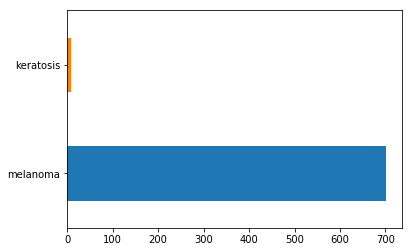

In [61]:
vis_classes(ia_no_nerus)

In [117]:
nervi_id = np.where(ia_nervi_id==False)[0]
non_n_id = np.where(ia_nervi_id)[0]
half_nervi = np.array(random.sample(nervi_id.tolist(), len(nervi_id)//2))
new_idxs = np.concatenate([half_nervi, non_n_id])

half_nervi_id = np.zeros(np.shape(ia_nervi_id)).astype(bool)
half_nervi_id[new_idxs] = True

half_nervi_df = ia.iloc[half_nervi_id,:]
half_nervi_df.head()

,melanoma,keratosis,classes
image,,,
isic_archive/images/558d637cbae47801cf734dbc.jpg,1,0,melanoma
isic_archive/images/558d60e8bae47801cf7345b2.jpg,1,0,melanoma
isic_archive/images/5508fed2bae47817cee4d183.jpg,0,0,nevus
isic_archive/images/558d60a0bae47801cf73440e.jpg,1,0,melanoma
isic_archive/images/5592cfca9fc3c131551458c6.jpg,1,0,melanoma


nevus        1667
melanoma      701
keratosis       9
Name: classes, dtype: int64


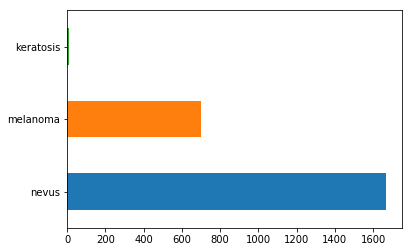

In [121]:
vis_classes(half_nervi_df)

## ISIC Challenge 17 Training Data

In [32]:
ict = getds('challenge')
ict.index = 'ISIC/ISIC-2017_Training_Data/' + ict['image'] + '.jpg'
ict = ict[['melanoma', 'keratosis']]
ict = add_class_col(ict)
ict.head()

adding melanoma to class
adding keratosis to class


/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,melanoma,keratosis,classes
image,,,
ISIC/ISIC-2017_Training_Data/ISIC_0000000.jpg,0,0,nevus
ISIC/ISIC-2017_Training_Data/ISIC_0000001.jpg,0,0,nevus
ISIC/ISIC-2017_Training_Data/ISIC_0000002.jpg,1,0,melanoma
ISIC/ISIC-2017_Training_Data/ISIC_0000003.jpg,0,0,nevus
ISIC/ISIC-2017_Training_Data/ISIC_0000004.jpg,1,0,melanoma


nevus        1372
melanoma      374
keratosis     254
Name: classes, dtype: int64


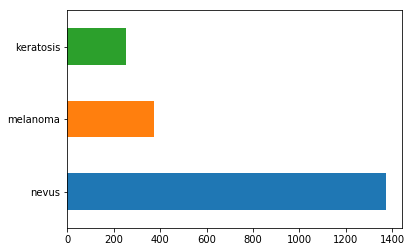

In [33]:
vis_classes(ict)

## Dermofit

In [171]:
ddf = getds('dermofit')
ddf = add_class_col(ddf)
# ddf.set_index(ddf['image'], inplace=True)
ddf.head()

adding melanoma to class
adding keratosis to class


,image,melanoma,keratosis,classes
image,,,,
D204a,D204a,0,0,nevus
D222,D222,0,0,nevus
D226b,D226b,0,0,nevus
D226c,D226c,0,0,nevus
D227,D227,0,0,nevus


In [174]:
ddf_t = pd.read_csv(PATH / 'dermofit/train.csv')
ddf_t.columns = ['image', 'class']

ddf_ids = ddf['image'].tolist()
ddf_pths = ddf_t['image'].tolist()
[os.path.basename(ss) for ss in ddf_pths] == ddf_ids
dermfit_image_id = ['dermofit/' + i + '.png' for i in ddf_pths]
print(all([(PATH / i).exists() for i in dermfit_image_id]))
ddf.index = dermfit_image_id
ddf.head()

,image,melanoma,keratosis,classes
dermofit/ALLBCC/D204a/D204a.png,D204a,0,0,nevus
dermofit/ALLSCC/D222/D222.png,D222,0,0,nevus
dermofit/ALLML/D226b/D226b.png,D226b,0,0,nevus
dermofit/ALLML/D226c/D226c.png,D226c,0,0,nevus
dermofit/ALLML/D227/D227.png,D227,0,0,nevus


nevus        967
keratosis    257
melanoma      76
Name: classes, dtype: int64


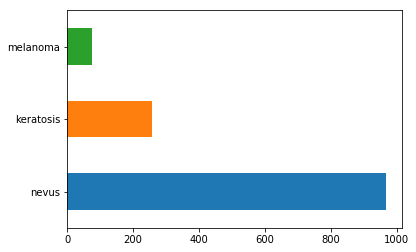

In [175]:
vis_classes(ddf)

## PH2 Dataset

In [176]:
pdf = getds('ph2')
pdf = add_class_col(pdf)
# pdf.set_index(pdf['image'], inplace=True)
pims = pdf['image'].tolist()
pims = ['ph2dataset/PH2_Dataset_images/'+i+f'/{i}_Dermoscopic_Image/{i}.bmp' for i in pims]
print(all([(PATH / ss).exists() for ss in pims]))
pdf.index = pims
# pdf = pdf[['melanoma', 'keratosis']]
pdf.head()

adding melanoma to class
adding keratosis to class
True


,image,melanoma,keratosis,classes
ph2dataset/PH2_Dataset_images/IMD003/IMD003_Dermoscopic_Image/IMD003.bmp,IMD003,0,0,nevus
ph2dataset/PH2_Dataset_images/IMD009/IMD009_Dermoscopic_Image/IMD009.bmp,IMD009,0,0,nevus
ph2dataset/PH2_Dataset_images/IMD016/IMD016_Dermoscopic_Image/IMD016.bmp,IMD016,0,0,nevus
ph2dataset/PH2_Dataset_images/IMD022/IMD022_Dermoscopic_Image/IMD022.bmp,IMD022,0,0,nevus
ph2dataset/PH2_Dataset_images/IMD024/IMD024_Dermoscopic_Image/IMD024.bmp,IMD024,0,0,nevus


nevus       80
melanoma    40
Name: classes, dtype: int64


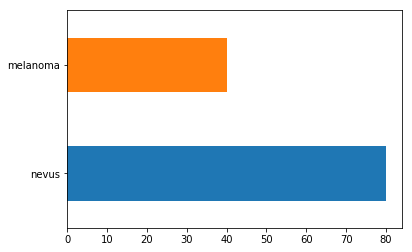

In [177]:
vis_classes(pdf)

## ISIC 17 Valdiation set

In [43]:
icv = pd.read_csv(PATH / 'val_isic17.csv')
icv.columns = ['image', 'class']

icv['melanoma'] = (icv['class'] == 'MEL').astype(int)
icv['keratosis'] = (icv['class'] == 'SK').astype(int)
icv.set_index(icv['image'], inplace=True)

icv.drop(columns=['class', 'image'], inplace=True)
icv = add_class_col(icv)
icv.head()

adding melanoma to class
adding keratosis to class


/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,melanoma,keratosis,classes
image,,,
ISIC/ISIC-2017_Validation_Data/ISIC_0001769.jpg,0,0,nevus
ISIC/ISIC-2017_Validation_Data/ISIC_0001852.jpg,0,0,nevus
ISIC/ISIC-2017_Validation_Data/ISIC_0001871.jpg,0,0,nevus
ISIC/ISIC-2017_Validation_Data/ISIC_0003462.jpg,0,0,nevus
ISIC/ISIC-2017_Validation_Data/ISIC_0003539.jpg,0,0,nevus


nevus        78
keratosis    42
melanoma     30
Name: classes, dtype: int64


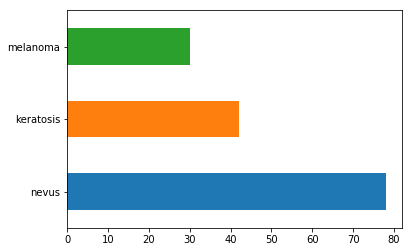

In [44]:
vis_classes(icv)

# Combine Datasets

nevus        4460
melanoma      847
keratosis     308
Name: classes, dtype: int64
5615


/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


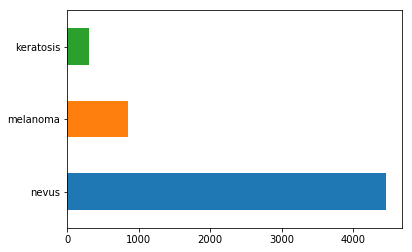

In [178]:
comb_all = pd.concat([ia, ddf, pdf, icv])
vis_classes(comb_all)
print(len(comb_all))

nevus        1125
melanoma      847
keratosis     308
Name: classes, dtype: int64
2280


/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


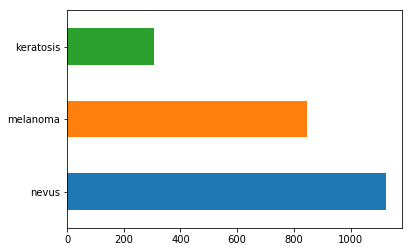

In [179]:
comb_no_ia_nervis = pd.concat([ia_no_nerus, ddf, pdf, icv])
vis_classes(comb_no_ia_nervis)
print(len(comb_no_ia_nervis))

In [187]:
train_raw_no_ia_nervi = PATH / 'train_multi_raw_no_ia_nervi.csv'
comb_no_ia_nervis.drop(columns='image').to_csv(train_raw_no_ia_nervi)

train_all_no_ia_nervi = PATH / 'train_multi_no_ia_nervi.csv'
comb_no_ia_nervis.drop(columns=['image', 'keratosis', 'melanoma']).to_csv(train_all_no_ia_nervi)


comb_no_ia_nervis.head()

,classes,image,keratosis,melanoma
isic_archive/images/558d637cbae47801cf734dbc.jpg,melanoma,NaN,0,1
isic_archive/images/558d60e8bae47801cf7345b2.jpg,melanoma,NaN,0,1
isic_archive/images/558d60a0bae47801cf73440e.jpg,melanoma,NaN,0,1
isic_archive/images/5592cfca9fc3c131551458c6.jpg,melanoma,NaN,0,1
isic_archive/images/558d6367bae47801cf734d38.jpg,melanoma,NaN,0,1


nevus        2792
melanoma      847
keratosis     308
Name: classes, dtype: int64
3947


/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


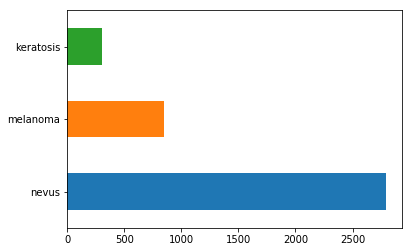

In [180]:
comb_half_ia_nervis = pd.concat([half_nervi_df, ddf, pdf, icv])
vis_classes(comb_half_ia_nervis)
print(len(comb_half_ia_nervis))
comb_half_ia_nervis.to_csv(train_raw_half_ia_nervi)

In [181]:
print(comb_half_ia_nervis.drop(columns=['image', 'keratosis', 'melanoma']).head())
train_all_half_ia_nervi = PATH / 'train_multi_half_ia_nervi.csv'
comb_half_ia_nervis.drop(columns=['image', 'keratosis', 'melanoma']).to_csv(train_all_half_ia_nervi)

                                                   classes
isic_archive/images/558d637cbae47801cf734dbc.jpg  melanoma
isic_archive/images/558d60e8bae47801cf7345b2.jpg  melanoma
isic_archive/images/5508fed2bae47817cee4d183.jpg     nevus
isic_archive/images/558d60a0bae47801cf73440e.jpg  melanoma
isic_archive/images/5592cfca9fc3c131551458c6.jpg  melanoma


In [182]:
os.path.exists(os.path.join(str(PATH), comb_half_ia_nervis.index[1]))
inv_idx =  [n for n in comb_half_ia_nervis.index if not isinstance(n, str)]
len(inv_idx)

0

# ISIC 17 Testset

nevus                   393
melanoma                117
seborrheic_keratosis     90
Name: classes, dtype: int64


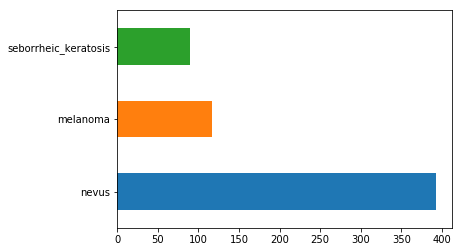

In [125]:
test_raw_p = PATH / 'ISIC/test_raw_17.csv'
test_df = pd.read_csv(test_raw_p)
vis_classes(test_df)

nevus                   393
melanoma                117
seborrheic_keratosis     90
Name: classes, dtype: int64


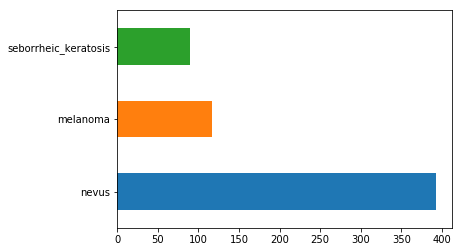

In [136]:
test_cls_p = PATH / 'ISIC/test_all_17.csv'
test_df = pd.read_csv(test_cls_p)
vis_classes(test_df)